# Advanced Lane Line Finding


In [1]:
# importlib reload vs jupyter autoreload
# from importlib import reload
# import module; reload(module)
%load_ext autoreload
%autoreload 1
%aimport preprocessing, lane_finding
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
import os
from preprocessing import *
from lane_finding import *

In [2]:
cal_dir = "camera_cal"
test_imgs_dir = "test_images"
out_imgs_dir = "output_images"
out_videos_dir = "output_videos"

### Get Test Images

In [3]:
test_img_paths = glob.glob(test_imgs_dir + "/*.jpg")
test_img_paths

['test_images/test6.jpg',
 'test_images/test5.jpg',
 'test_images/test4.jpg',
 'test_images/test1.jpg',
 'test_images/test3.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/straight_lines1.jpg']

In [4]:
test_imgs = [load_image(img) for img in test_img_paths]

In [5]:
def get_test_img_name(test_img_path):
    name_plus_ending = test_img_path.split('/')[1]
    name = name_plus_ending.split('.')[0]
    return name
    
test_img_names = [get_test_img_name(path) for path in test_img_paths]
test_img_names

['test6',
 'test5',
 'test4',
 'test1',
 'test3',
 'test2',
 'straight_lines2',
 'straight_lines1']

# Camera Calibration and Undistortion
Let's first get the paths of all our calibration images. Note, when loading images with imread, they get stored in BGR color format. When using imshow, however, we need them in RGB color format. Therefore, we create in utils.py a convenience function load_img that loads the image and converts into RGB color format.

In [6]:
cal_img_paths = glob.glob(cal_dir + "/*.jpg")
print(len(cal_img_paths))

20


There are 20 images in the calibration image directory. Let's now take a look at the first chessboard image to see what it looks like. 

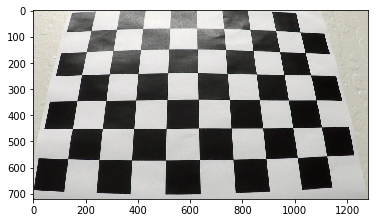

In [7]:
cal_img = load_image(cal_img_paths[4])
plt.imshow(cal_img)

### Finding and Drawing Chessboard Corners

The Chessboard has 9x6 inner corners. We now use these parameters for the function `cv2.findChessboardCorners()`.

In [8]:
nx = 9
ny = 6

First of all, we feed the function a grayscaled image. 

In [9]:
gray = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY)

Now, we test the above functions with the first of the calibration images. 

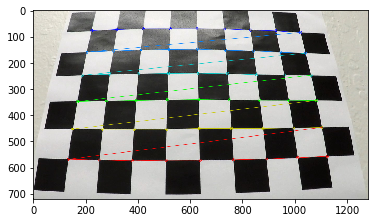

In [10]:
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
    plt.imshow(cal_img)

The corner detection seems to be working, however not for all calibration images. Some images are too small, i.e. not all corners are visible. Next, we will use the found corners to undistort the camera. 

## Camera Calibration
With the above functions, we now create the camera matrix and the distortion coefficients. Therefore, we first need to define image points and object points of the chessboard corners. 

### Find Image and Object Points
For distortion correction, we map the 2D chessboard corners in the image, the so-called image points, onto the 3D chessboard corners in the "real world", the so-called object points. We compute image- and object points from all calibration images in the calibration image path. 

The opencv function `calibrate camera` uses these image and object points to determine the camera matrix and the distortion coefficient. 

### Camera Calibration
We now create a camera calibration pipeline that takes in the calibration image path as well as the number of chessboard corners `nx` and `ny` and returns the camera matrix `mtx` and distortion `dist`. We can save the found camera matrix and distortion coefficients, so we don't have to calculate them every time. We save them in `calibration_coefficients/mtx_dst`.

We now calibrate our camera. For calibrating the camera, the function needs one test image, because it needs its shape for determining the camera matrix. 

In [11]:
mtx, dist = calibrate_camera(img=test_imgs[0], cal_img_path=cal_img_paths, nx=9, ny=6)
img_points, obj_points = get_image_object_points(cal_img_paths, nx=9, ny=6)

## Undistortion
First of all, we test our calibration and undistortion pipeline on a calibration image. The opencv function `cv2.undistort` uses the above `mtx` and `dist` to undistort images.

First, we test the undistortion on a calibration image. 

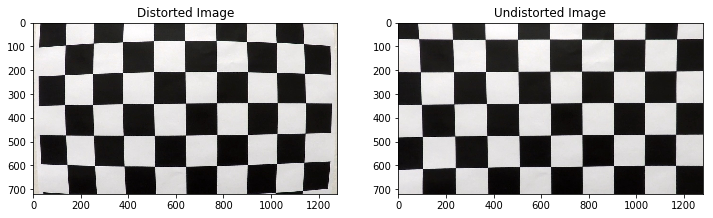

In [12]:
cal_img_example = load_image(cal_img_paths[6])
cal_img_example_undistort = undistort_img(cal_img_example, mtx, dist)
fig, ax = plt.subplots(1, 2, figsize=(12, 14))
ax[0].imshow(cal_img_example)
ax[0].set_title('Distorted Image')
ax[1].imshow(cal_img_example_undistort)
ax[1].set_title('Undistorted Image')
plt.show()

This does works reasonably well, but not perfectly on all calibration images.

### Undistorting all test images


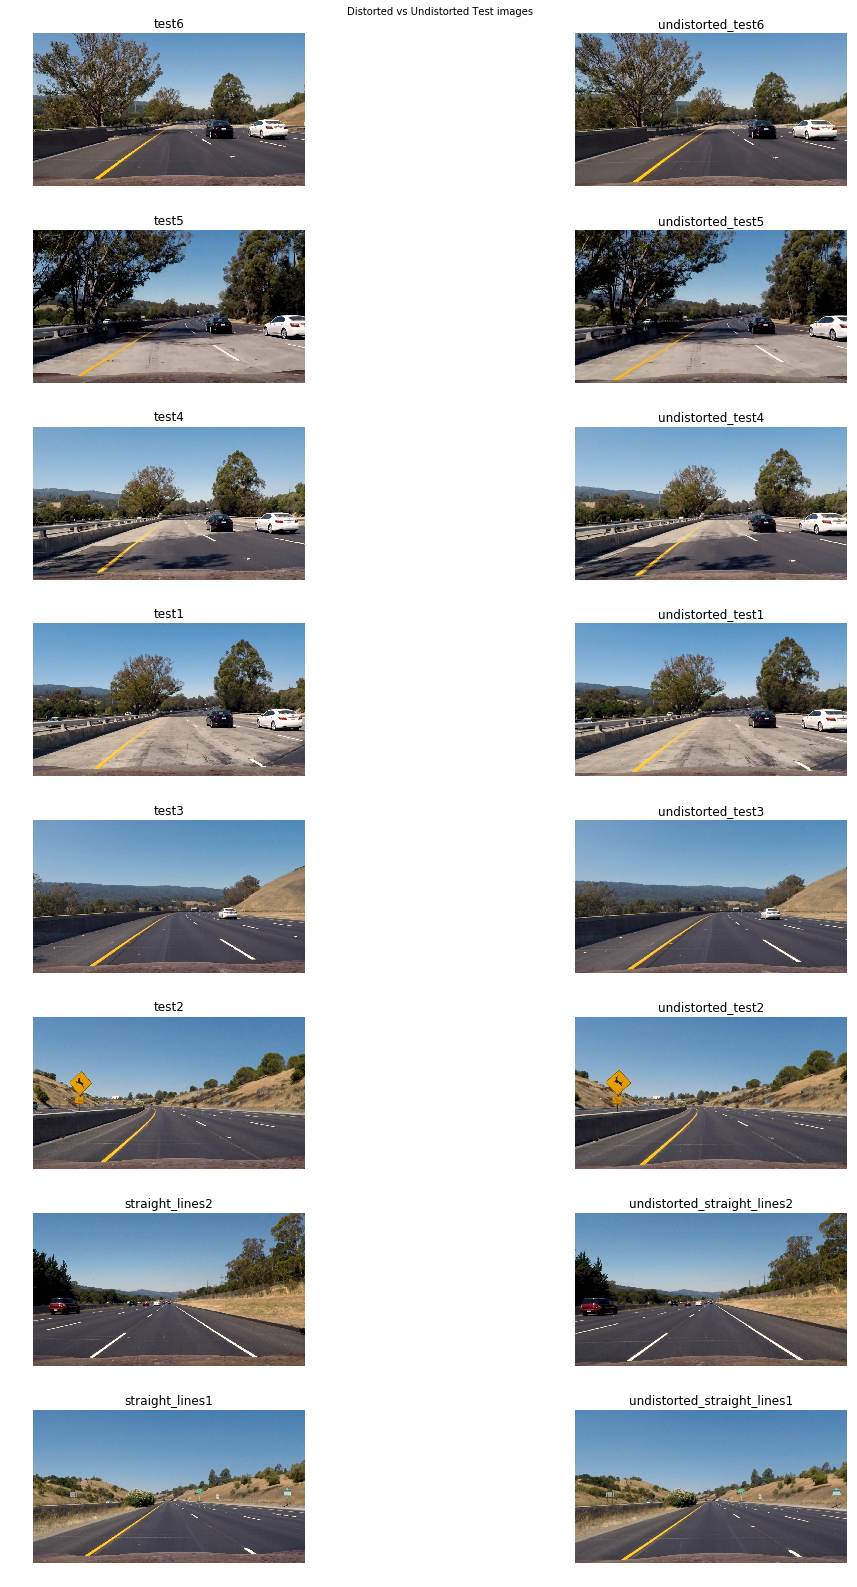

In [13]:
undist_test_imgs = [undistort_img(test_img, mtx, dist) for test_img in test_imgs]
undist_test_img_names = ['undistorted_' + test_img_name for test_img_name in test_img_names]
show_img_lists([test_imgs, undist_test_imgs], [test_img_names, undist_test_img_names], 
                     title="Distorted vs Undistorted Test images", figsize=(18, 22))

As we can see, in the undistorted mode, the traffic signs and cars can be seen more from the front.

# Thresholding
In order to find pixels that are likely to be part of a line, we apply  color thresholding as well as gradient thresholding in this section. This will make it easier to later find a polynomial that fits the lane lines well. 

## Color Thresholds
First of all, we set color thresholds. This can be done, for example, in RGB or HSL space. First of all we define a color thresholding function that applies thresholds to an image's color channel.

Next, we want to see which compare which of the RGB channels are best suited for detecting lane lines. We take one test image and compare grayscale - R - G - B - Hue - Saturation - Lightness.

In [14]:
rgb_img = undist_test_imgs[0]
gray_img = utils.grayscale(rgb_img)
hls_img = utils.hls(rgb_img)

gray_channel = gray_img
r_channel = rgb_img[:, :, 0]
g_channel = rgb_img[:, :, 1]
b_channel = rgb_img[:, :, 2]
h_channel = hls_img[:, :, 0]
l_channel = hls_img[:, :, 1]
s_channel = hls_img[:, :, 2]

channel_imgs = [gray_channel, r_channel, g_channel, b_channel, h_channel, l_channel, s_channel]
channel_names = ['grayscale', 'R channel', 'G channel', 'B channel', 'H channel', 'L channel', 'S channel']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
for idx, ax in enumerate(axes.flat):
    if (idx < len(channel_names)):
        ax.imshow(channel_imgs[idx], cmap='gray')
        ax.set_title(channel_names[idx])
    ax.axis("off")

plt.suptitle('Different color channels in testimg[0]')
plt.tight_layout()
plt.show()
                         


NameError: name 'utils' is not defined

We can see that the lines are best distinguishable in the R channel and especially in the HSL image's saturation channel. We can thus set a threshold on the S channel. As in the lectures, we set thresh = (90, 255)


In [ ]:
hls_imgs = [utils.hls(img) for img in undist_test_imgs]
color_thresh_imgs = [color_threshold(img, channel=2, low=90, high=255) for img in hls_imgs]
color_thresh_imgs_names = test_img_names

In [ ]:
ncols=2
nrows = len(test_img_names) //2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for idx, ax in enumerate(axes.flat):
    ax.imshow(color_thresh_imgs[idx], cmap='gray')
    ax.set_title(color_thresh_imgs_names[idx])
    ax.axis("off")
plt.suptitle('Thresholding on Saturation Channel')
# plt.tight_layout()
plt.show()

As we can see, the color thresholding works and the lane lines are clearly visible.

## Gradient Thresholds
In the last exercise we used Canny edge detection to find possible lane lines in the image. Canny finds all possible lines in an image. Looking at lane lines, however, we have a smarter way for filtering pixels, because we know that the relevant lines are close to vertical. 

In the lectures, we saw that the sobel_x operator calculates the gradient in x-direction. Therefore, it emphasizes lines that are closer to the vertical and discards lines that are close to horizontal. This is what we need for finding lane lines.

### Sobel Operator

The Sobel operator needs pictures in grayscale. It has a kernel parameter, which determines how smooth the gradients are going to be. The kernel size can be any odd number. After converting the image with the Sobel operator, we define thresholds `thresh_min` and `thresh_max` that decide whether a detected line is kept or discarded. The Sobel operator lets us create a binary threshold to select pixels based on gradient strength: Pixels with strong gradient are kept, and strong gradients signify strong lines.

In the lecture, a threshold of `(30, 100)` was proven successful. In addition to the threshold parameters, Sobel operator needs us to specify a kernel size. The kernel size can be any odd number greater than or equal to 3. A larger kernel implies taking the gradient over a larger region of the image, or, in other words, a smoother gradient.



### Absolute Sobel Threshold

Now we have to find good values for `thresh_min` and `thresh_max` as well as a kernel size that works well. 

### Comparing kernel sizes: x-direction
Before we define good gradient thresholds, we want to compare different kernel sizes. Let's compare `k=5`, `k=7`, `k=9`, `k=11` and `k=15`. We apply the sobel threshold on a test image. First, we look at the Sobel operator in x-direction.

In [ ]:
sobel_test_img = test_imgs[0]

In [ ]:
sobel5 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=5)
sobel5_name = test_img_names[0]+ ' 5x5 kernel, x-direction'
sobel7 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=7)
sobel7_name = test_img_names[0]+ ' 7x7 kernel, x-direction'
sobel9 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=9)
sobel9_name = test_img_names[0]+ ' 9x9 kernel, x-direction'
sobel11= abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=11)
sobel11_name = test_img_names[0]+ ' 11x11 kernel, x-direction'
sobel15 = abs_sobel_thresh(sobel_test_img, orient='x', thresh_min=30, thresh_max=100, ksize=15)
sobel15_name = test_img_names[0]+ ' 15x15 kernel, x-direction'

sobel_imgs = [sobel5, sobel7, sobel9, sobel11, sobel15]
sobel_names = [sobel5_name, sobel7_name, sobel9_name, sobel11_name, sobel15_name]

In [ ]:
ncols = 3
nrows = len(sobel_imgs) // ncols + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
for idx, ax in enumerate(axes.flat):
    if(idx < len(sobel_imgs)):
        ax.imshow(sobel_imgs[idx], cmap='gray')
        ax.set_title(sobel_names[idx])
    ax.axis("off")
plt.suptitle('Comparison of different kernel sizes for Sobel operator')
plt.tight_layout()
plt.show()

We see that a kernel size of 15 works best. The difference between the kernel sizes, however, is relatively small.

## Combining Color and Gradient Thresholds

Now let's test the combined thresholds on a test image. 

In [ ]:
undist_test_imgs[0].shape

In [ ]:

combined_binary, color_binary = color_gradient_threshold(undist_test_imgs[0], plot=True)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [ ]:
binary_imgs = [color_gradient_threshold(img) for img in undist_test_imgs]
binary_imgs_names = [name + ' binary' for name in test_img_names]

The result looks quite good! Now we can go to the next step: Perspective Transform.

## Perspective Transform
We now want to transform the image perspective to a bird's eye view. To do this, we need to define a trapezoid shape in our source image that will be transformed into a rectangle in the destination image. Like in the lecture, the trapezoid and rectangle are defined manually. Then, we will use opencv's `get_perspective_transform()` function.

In the following image, we can see the lane markings particularly well.

In [ ]:
plt.imshow(test_imgs[4])

We now try and fit a trapezoid into this image.

In [ ]:
# copy test image since we're going to draw on it.
test_p_trafo = np.copy(undist_test_imgs[4])
(bottom_px, right_px) = (test_p_trafo.shape[0] - 1, test_p_trafo.shape[1] - 1) 
pts = np.array([[230,bottom_px],[610,450],[700,450], [1130, bottom_px]], np.int32)
cv2.polylines(test_p_trafo,[pts],True,(255,0,0), 10)
plt.imshow(test_p_trafo)

We have found the four points that define our trapezoid. For the destination points we choose two points that lie on the top and bottom line of the image and that are 

Let's now try these transforms out, first on the test images and then on the binary images from above. We plot the original image next to the warped image

In [ ]:
test_imgs_warped = [get_perspective_transform(img)[0] for img in undist_test_imgs]
test_imgs_warped_names = [name + ' warped' for name in test_img_names]


In [ ]:
show_img_lists(image_lists=[test_imgs, test_imgs_warped], image_names=[test_img_names, test_imgs_warped_names],
                    title='Before and after perspective transform')

The result looks good. Now we test the function also on our binary images:


In [ ]:
binary_imgs_warped = [get_perspective_transform(img)[0] for img in binary_imgs]
binary_imgs_warped_names = [name + ' binary warped' for name in test_img_names]

In [ ]:
show_img_lists(image_lists=[binary_imgs, binary_imgs_warped], 
                     image_names=[binary_imgs_names, binary_imgs_warped_names],
                    title='Before and after perspective transform')

# Preprocessing Pipeline
Now the image preprocessing is done. We write a pipeline:

In [ ]:
# mtx and dist have been calculated above
def preprocess_image(img):
    """Applies all image preprocessing steps before lane detection."""
    # undistort image with the previously calculated `mtx` and `dst`
    undist_img = undistort_img(img, mtx=mtx, dist=dist)
    # apply color and gradient thresholding to get a binary image
    binary_img = color_gradient_threshold(undist_img)
    # apply perspective transform to get a warped image
    binary_warped_img, M, Minv = get_perspective_transform(binary_img)
    
    return warped_img, M, Minv

## Finding the Lane Pixels: Histogram Peaks

In [ ]:
from lane_finding import *

The initial lane line pixels are determined via the sliding window approach. Once that is done, we can have it easier by searching from prior. Therefore, however, our lines need some kind of memory:

## Test on Video Files


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

LF = LaneFinder()
print(type(LF))
white_output = 'project_video_output'
video_output_white = VideoFileClip("project_video.mp4")
video_white = clip1.fl_image(LF.find_lanes)
video_white.write_videofile(video_output_white, audio=False)


In [ ]:
os.listdir()